In [9]:
import scvi
from scvi.model import CondSCVI, DestVI
import torch
import anndata
import scanpy as sc
import numpy as np

In [2]:
sc_anndata = anndata.read_h5ad('../Condor/bayestme/sc_ref/reference_3.h5ad')

In [3]:
sc_anndata.obs["broad_cell_types"] = sc_anndata.obs['annotation_1'].values
G = 300
sc.pp.filter_genes(sc_anndata, min_counts=10)
sc_anndata.layers["counts"] = sc_anndata.X.copy()
sc.pp.highly_variable_genes(
    sc_anndata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_anndata, target_sum=10e4)
sc.pp.log1p(sc_anndata)
sc_anndata.raw = sc_anndata

In [7]:
CondSCVI.setup_anndata(sc_anndata, layer="counts", labels_key="broad_cell_types")
sc_model = CondSCVI(sc_anndata, weight_obs=False)
CondSCVI.view_anndata_setup(sc_model)
sc_model.train()

Anndata setup with scvi-tools version 0.16.2.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'broad_cell_types', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2950  │
│      n_vars      │  300  │
│     n_labels     │   3   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['broad_cell_types'] │  Ext_L56   │          0          │
│                               │ Ext_Thal_1 │          1          │
│                               │ Inh_Lamp5  │          2          │
└───────────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 300/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:35<00:00,  3.14it/s, loss=630, v_num=1]


In [13]:
st_anndata = anndata.read_h5ad('../Condor/bayestme/sc_ref/observation_3.h5ad')
st_anndata.obsm['location'] = st_anndata.obsm['spatial']
st_anndata.obs["n_counts"] = np.sum(st_anndata.X, axis=1)
st_anndata.layers["counts"] = st_anndata.X.copy()
st_anndata.obsm['spatial'] = st_anndata.obsm['location']

sc.pp.normalize_total(st_anndata, target_sum=10e4)
sc.pp.log1p(st_anndata)
st_anndata.raw = st_anndata

DestVI.setup_anndata(st_anndata, layer="counts")
st_model = DestVI.from_rna_model(st_anndata, sc_model)
st_model.train(max_epochs=2500)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2500/2500: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:04<00:00, 20.13it/s, loss=5.02e+05, v_num=1]


In [14]:
DestVI.setup_anndata(st_anndata, layer="counts")
st_model = DestVI.from_rna_model(st_anndata, sc_model)
st_model.train(max_epochs=2500)
st_anndata.obsm["proportions"] = st_model.get_proportions()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/hrzhang/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2500/2500: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:03<00:00, 20.25it/s, loss=5.12e+05, v_num=1]


In [20]:
st_anndata.obsm["proportions"].to_csv('test.csv')

In [22]:
import pandas as pd

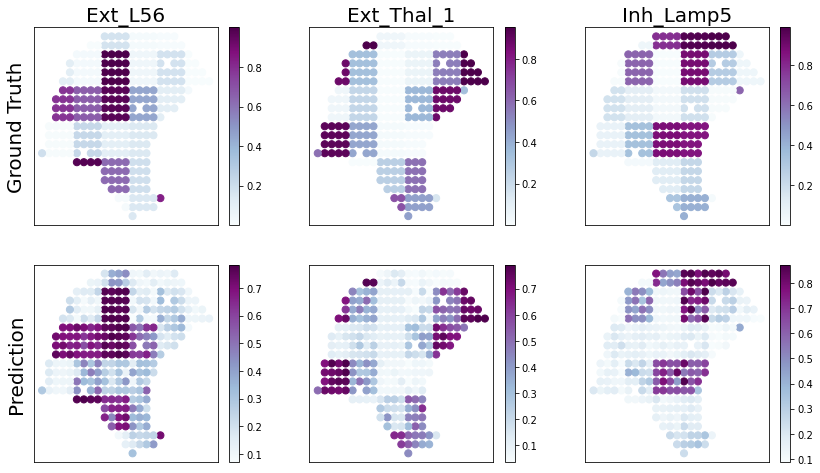

In [28]:
import matplotlib.pyplot as plt
import SGE.python.plot_st_data as st_plt
path = '/Users/hrzhang/Dropbox/jac/'
pos = np.load(path+'semisyn_3_pos.npy')
Truth_prior = np.load(path+'semi_syn_melanoma_3_Truth_prior.npy')
post_prob = pd.read_csv('../Condor/bayestme/results/destvi_3_3.csv').values[:, 1:].astype(float)
cell_name = ['Ext_L56', 'Ext_Thal_1', 'Inh_Lamp5']
reorder = [1, 0, 2]
n_components = post_prob.shape[-1]
fig, ax = plt.subplots(2, n_components, figsize=(4*n_components+2, 8))
for k in range(n_components):
    im = st_plt.plot_spots(ax[0, k], Truth_prior[:, k], pos[::-1], s=50, cmap='BuPu')
    plt.colorbar(im, ax=ax[0, k])
    ax[0, k].set_xticks([])
    ax[0, k].set_yticks([])
    ax[0, k].set_title(cell_name[k], fontsize=20)
#     ax[0, k].invert_xaxis()
#     ax[0, k].invert_yaxis()
    im = st_plt.plot_spots(ax[1, k], post_prob[:, reorder[k]], pos[::-1], s=50, cmap='BuPu')
    plt.colorbar(im, ax=ax[1, k])
    ax[1, k].set_xticks([])
    ax[1, k].set_yticks([])
#     ax[1, k].invert_xaxis()
#     ax[1, k].invert_yaxis()
ax[0, 0].set_ylabel('Ground Truth', fontsize=20)
ax[1, 0].set_ylabel('Prediction', fontsize=20)
plt.show()

In [26]:
pd.read_csv('../Condor/bayestme/results/destvi_3_3.csv').values[:, 1:]

array([[0.045011196, 0.16158697, 0.79340184],
       [0.04244473, 0.10143407, 0.8561212],
       [0.052249033, 0.111220986, 0.83653],
       [0.041505292, 0.09434054, 0.8641542],
       [0.06623779, 0.150852, 0.78291017],
       [0.04019507, 0.093684934, 0.86612],
       [0.045883775, 0.10202832, 0.8520879],
       [0.11707922, 0.4458327, 0.437088],
       [0.14431593, 0.39663038, 0.4590537],
       [0.07531831, 0.36947227, 0.5552094],
       [0.046236046, 0.18442741, 0.7693366],
       [0.04218586, 0.10482874, 0.8529854],
       [0.04756862, 0.10824229, 0.84418905],
       [0.054250725, 0.116538115, 0.8292112],
       [0.035129756, 0.09415783, 0.8707124],
       [0.0626108, 0.14926104, 0.78812814],
       [0.09080593, 0.08403828, 0.8251558],
       [0.039519727, 0.10248786, 0.8579924],
       [0.045507494, 0.16578516, 0.7887073],
       [0.20390575, 0.26696208, 0.5291322],
       [0.08171313, 0.42409423, 0.49419263],
       [0.1278841, 0.4301054, 0.44201052],
       [0.08220403, 0.200